We will test the accuracy of the algorithm with artificially generated data 


We will have a total of 5 states and a total of 8 possible clusters for the hosts to be part of.


Based on these clusters and their centroid transition matrix, a data series will be generated for each host

First set the parameters of the states

In [199]:
import numpy as np

lambdas = np.vstack([[0,0], [15,20], [37,12], [7,48], [55,75]])
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

# random plot of the data
# number of points to take from each distribution centroid
size = 1000

for i, lambda_i in enumerate(lambdas):
    s1 = np.random.poisson(lambda_i[0], size)
    s2 = np.random.poisson(lambda_i[1], size)

    if i == 0:
        data = np.column_stack((s1, s2, np.array([i]*size, dtype=object)))
    else:
        data = np.append(data, np.column_stack((s1, s2, np.array([i]*size, dtype=object))), axis=0)

np.random.shuffle(data)

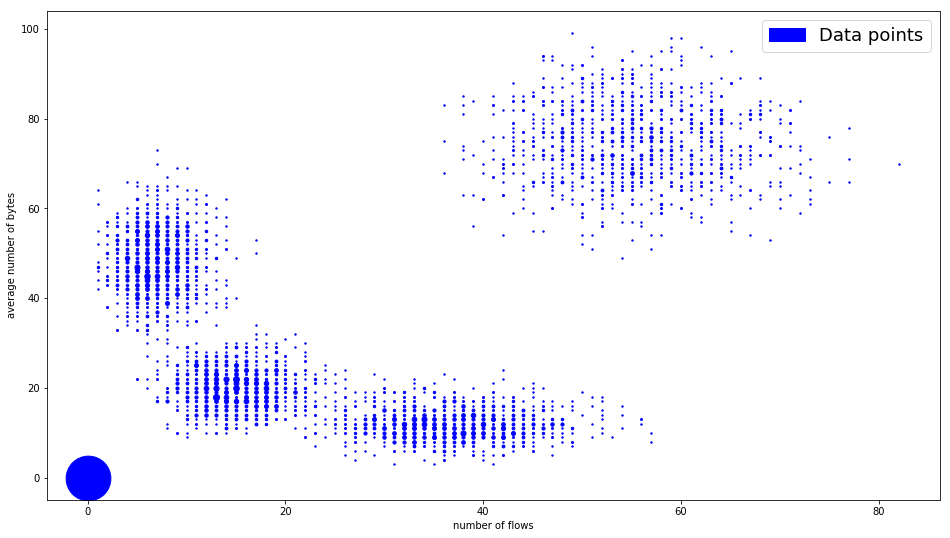

In [200]:
from plots import plot_points
%matplotlib inline

plot_points(data[:, :2])

As we can see the clusters are clearly seperated 

More precisely based only on the mass function of the distributions, the accuracy is as following

In [201]:
import scipy.stats.distributions


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

correct_classified = 0
for point in data:
    classification = np.argmax([poisson(point[:2], lambda_i) for lambda_i in lambdas])
    if classification == point[2]:
        correct_classified += 1
        
print('Accuracy of origin cluster based on mass function', correct_classified / len(data) * 100, '%')

Accuracy of origin cluster based on mass function 99.62 %


Now we will create the clusters

A total of 8 clusters will be generated each containing 25 hosts

In [261]:
import random as ran

L = 9
num_hosts_per_L = [10, 20, 30, 40, 50, 60, 70, 80, 150]

def random_vector(size=5):
    vec = [ran.random() for i in range(size)]
    return np.array(vec) / sum(vec)

def random_transition_matrix(size=5):
    return np.vstack([random_vector(size=size) for i in range(size)])

In [262]:
transition_matrices = []
for i in range(L):
    transition_matrices.append(random_transition_matrix(size=len(lambdas)))

Create the points for each individual host

In [263]:
data_points = []
number_of_epochs = 500

def add_random_points(data_points, host_name, distribution, lambdas, epoch):
    axis0 = np.random.poisson(lambdas[distribution][0], 1)[0]
    axis1 = np.random.poisson(lambdas[distribution][1], 1)[0]
    data_points.append([axis0, axis1, epoch, host_name])

def random_next_state(transition_matrices, i, previous_distribution):
    r = ran.random()
    return np.where(transition_matrices[i][previous_distribution].cumsum() >= r)[0][0]
    
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        # random starting distribution
        previous_distribution = ran.randint(0, len(lambdas) - 1)
        add_random_points(data_points, host_name, previous_distribution, lambdas, 1)
        
        for k in range(2, number_of_epochs + 1):
            next_distribution = random_next_state(transition_matrices, i, previous_distribution)
            
            add_random_points(data_points, host_name, next_distribution, lambdas, k)
            
            previous_distribution = next_distribution
            

data_points = np.array(data_points,  dtype=object)

Run the EM Algorithm and the clustering

An important note is that the EM mixtures might not converge from the beginning to the desired points so on the starting epochs some of the results might not be the desired ones. This should not be a problem though.

In [264]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus
import numpy as np
import pandas as pd

In [271]:
mixtures = len(lambdas)

kplusplus = KPlusPlus(mixtures, data_points[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5


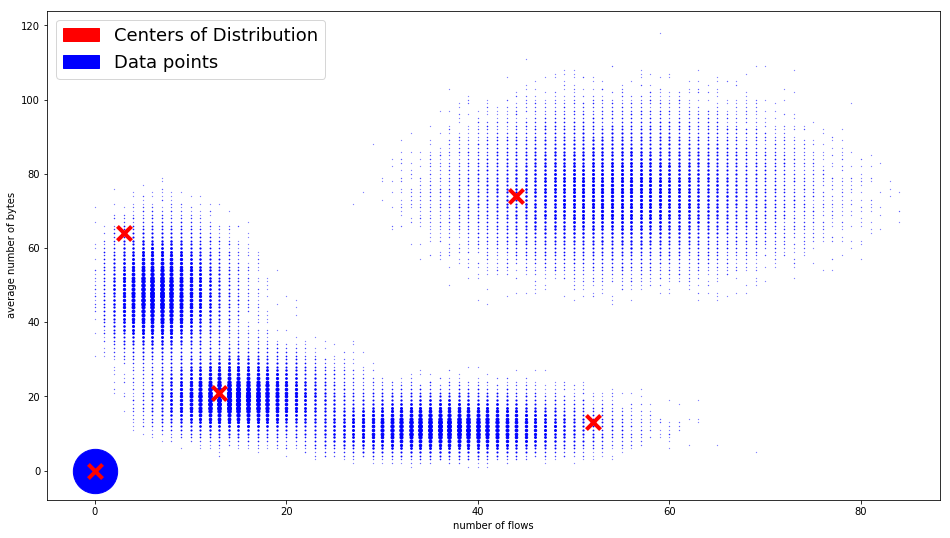

In [272]:
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, sum(num_hosts_per_L), verbose=0, update_power=0.5)

plot_points(data_points[:, :2], onlineEM)

In [273]:
onlineEM.fit(data_points[:,[0,1,3]])

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


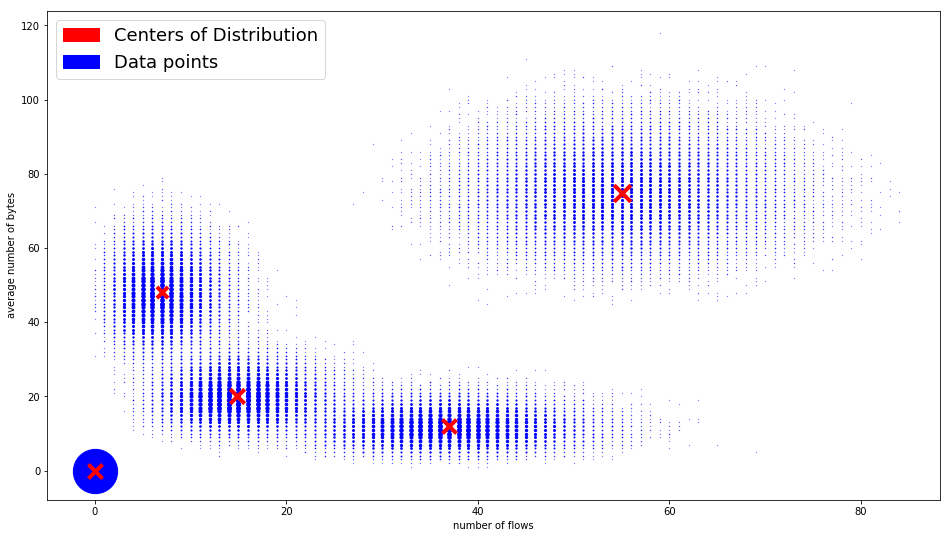

In [274]:
plot_points(data_points[:, :2], onlineEM)

In [275]:
print(onlineEM.gammas)
print(onlineEM.lambdas)

[ 0.19984116  0.20656532  0.27465601  0.19314196  0.12579556]
[[0.0 0.0]
 [14.890752244193321 20.011096961143625]
 [55.022648883637878 74.843926688728999]
 [37.012301187496561 12.037824469634593]
 [7.0001456379664289 48.088363820773978]]


Now we can cluster the transition matrices 

In [276]:
#from klkmeans import kMeans

kmeans = kMeans(onlineEM, n_clusters=L, initial_centers=None, n_iters=15, n_runs=10)
C, assign = kmeans.run()

Starting run
The cost is 25.5834426572
The cost is 21.4848977736
The cost is 16.0035505992
The cost is 15.9874540238
The cost is 15.9816920644
The cost is 15.9789151424
The cost is 15.97624558
The cost is 15.9756481119
converged
Starting run
The cost is 18.857779839
The cost is 5.89898439494
The cost is 5.36780557949
converged
Starting run
The cost is 22.1892600022
The cost is 10.0377203921
The cost is 6.74798056063
The cost is 6.33730554619
converged
Starting run
The cost is 19.6803115376
The cost is 12.1591810881
The cost is 12.0486502829
The cost is 11.4993220911
The cost is 10.7576027526
The cost is 9.77741782307
The cost is 8.88629326826
converged
Starting run
The cost is 20.0622755125
The cost is 15.3156941309
The cost is 14.8990182401
converged
Starting run
The cost is 19.6051281105
The cost is 18.0478466956
converged
Starting run
The cost is 18.6109444609
The cost is 16.6664998565
The cost is 14.2543541089
The cost is 14.2497853007
converged
Starting run
The cost is 12.83405880

In [277]:
centroids = np.zeros(shape=(L, L), dtype=np.int64)
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        
        participation = assign[host_name]
        centroids[i][participation] += 1
    
centroids

array([[  0,  10,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  20,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  30,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  40],
       [ 50,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  60,   0],
       [  0,   0,  70,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  80,   0,   0],
       [  0,   0,   0,   0,   0, 150,   0,   0,   0]], dtype=int64)